In [15]:
import pennylane as qml
from pennylane import numpy as np
import time

def local_hadamard_test(weights, problem, l=None, lp=None, j=None, part=None):

    ancilla_idx = problem.get_n_qubits()

    # First Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # For estimating the imaginary part of the coefficient "mu", we must add a "-i"
    # phase gate.
    if part == "Im" or part == "im":
        qml.PhaseShift(-np.pi / 2, wires=ancilla_idx)

    # Variational circuit generating a guess for the solution vector |x>
    problem.variational_block(weights)

    # Controlled application of the unitary component A_l of the problem matrix A.
    problem.CA(ancilla_idx, l)

    # Adjoint of the unitary U_b associated to the problem vector |b>.
    # In this specific example Adjoint(U_b) = U_b.
    problem.U_b()

    # Controlled Z operator at position j. If j = -1, apply the identity.
    if j != -1:
        qml.CZ(wires=[ancilla_idx, j])

    # Unitary U_b associated to the problem vector |b>.
    problem.U_b()

    # Controlled application of Adjoint(A_lp).
    # In this specific example Adjoint(A_lp) = A_lp.
    problem.CA(ancilla_idx, lp)

    # Second Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # Expectation value of Z for the ancillary qubit.
    return qml.expval(qml.PauliZ(wires=ancilla_idx))

def hadamard_overlap_test(weights, problem, l=None, lp=None, part=None):
    n_qubits = problem.get_n_qubits()
    ancilla_idx = n_qubits * 2

    # H on ancilla index
    qml.Hadamard(ancilla_idx)

    # Variational circuit generating a guess for the solution vector |x> applied to the top half
    problem.variational_block(weights, offset=n_qubits)

    # unitary U_b associated to the problem vector |b> applied to the bottom half
    # In this specific example Adjoint(U_b) = U_b.
    problem.U_b()

    # Controlled application of the unitary component A_l of the problem matrix A on the top half.
    problem.CA(ancilla_idx, l, offset=n_qubits)

    # Controlled application of Adjoint(A_lp) applied to the bottom half
    # In this specific example Adjoint(A_lp) = A_lp. #TODO: is it really?
    problem.CA(ancilla_idx, lp)

    if part == "Im":
        qml.RZ(phi=-np.pi/2, wires=ancilla_idx)

    # bell basis observable
    [qml.CNOT(wires=(i+n_qubits, i)) for i in range(n_qubits)]
    [qml.Hadamard(wires=i) for i in range(n_qubits, n_qubits*2 + 1)]

    # to get P(0) - P(1) we need to perform linear classical post-processing which involves using the probabilities
    return qml.probs(wires=range(n_qubits*2 + 1))


# Computes the mu coefficients
def mu(weights, local_hadamard_test, problem, l=None, lp=None, j=None):
    """Generates the coefficients to compute the "local" cost function C_L."""

    mu_real = local_hadamard_test(weights, problem, l=l, lp=lp, j=j, part="Re")
    mu_imag = local_hadamard_test(weights, problem, l=l, lp=lp, j=j, part="Im")

    return mu_real + 1.0j * mu_imag

def psi_norm(weights, c, local_hadamard_test, problem):
    """Returns the normalization constant <psi|psi>, where |psi> = A |x>."""
    norm = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            norm = norm + c[l] * np.conj(c[lp]) * mu(weights, local_hadamard_test, problem, l, lp, -1)

    return abs(norm)

def get_bin(state: int, n_qubits):
    """
    @param
    state: a measurement outcome as an int 
    return: (-1 or 1, corresponding to whether the prob on the bitstring should be added or subtracted)
    """
    acc = 1

    # if aux qubit is 1
    if state & 2**(n_qubits*2):
        acc *= -1

    for i in range(n_qubits):
        if state & 2**i and state & 2**(i + n_qubits):
            acc *= -1

    return acc

def gamma(weights, hadamard_overlap_test, problem, l=None, lp=None):
    n_qubits = problem.get_n_qubits()

    probs_real = hadamard_overlap_test(weights, problem, l=l, lp=lp, part="Re")
    probs_imag = hadamard_overlap_test(weights, problem, l=l, lp=lp, part="Im")

    gamma_real = 0
    gamma_imag = 0

    for state, prob in enumerate(probs_real):
        gamma_real += get_bin(state, n_qubits) * prob
    
    for state, prob in enumerate(probs_imag):
        gamma_imag += get_bin(state, n_qubits) * prob

    # print(f"gamma: {time.time() - start:.2f}")

    return 2 * (gamma_real + 1.0j * gamma_imag) # see appendix C for the 2x coeff

def cost_global(problem, weights, local_hadamard_test, hadamard_overlap_test):
    """Global version of the cost function. Tends to zero when A|x> is proportional to |b>."""
    c, _ = problem.get_coeffs()

    norm = 0.0
    overlap = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            # start = time.time()
            norm = norm + c[l] * np.conj(c[lp]) * mu(weights, local_hadamard_test, problem, l, lp, -1)
            # print(f"norm accum ({l*len(c) + lp})")

            overlap = overlap + c[l] * np.conj(c[lp]) * gamma(weights, hadamard_overlap_test, problem, l, lp)

    norm = abs(norm)
    overlap = abs(overlap)

    # print(norm, overlap)

    return 1 - overlap / norm # TODO: double check this expression

# convert matrix A encoded as a string (eg. "IZZ") into qml code
def A_to_code (idx, ancilla_idx, terms, offset=0):

    if idx < 0:
        raise ValueError("Index of linear combination must be >= 0.")
    
    target_pauli = list(terms[idx])
    
    order_idx = offset

    for i in range(len(target_pauli)):
        if target_pauli[i] == 'I':
            order_idx += 1
            None
        if target_pauli[i] == 'X':
            qml.CNOT(wires = (ancilla_idx, order_idx))
            order_idx += 1
        if target_pauli[i] == 'Y':
            qml.CY(wires = (ancilla_idx, order_idx))
            order_idx += 1
        if target_pauli[i] == 'Z':
            qml.CZ(wires = (ancilla_idx, order_idx))
            order_idx += 1

import functools as ft

pauli_dict = {"I": qml.Identity.compute_matrix(), "X": qml.PauliX.compute_matrix(), "Y": qml.PauliY.compute_matrix(), "Z": qml.PauliZ.compute_matrix()}

def A_to_num (n_qubits: int, coefs: np.tensor, terms):
    """
    Given an array of coeffs c and an array of A_l formatted as a list of strings, return A
    @params
    coefs (eg. [1, 0.2, 0.2])
    terms (eg. ["III", "XZI", "XII"])

    returns an np.array
    """    
    if len(coefs) != len(terms):
        raise ValueError("Number of coefficients does not match number of terms.")
    
    if n_qubits <= 0:
        raise ValueError("Number of qubits is not a number greater than 0.")
    
    terms_len = len(terms)
    for i in range(terms_len):
        if len(terms[i]) != n_qubits:
            raise ValueError("Number of terms in each Pauli gate combination must be the same as number of qubits.")
        

    dim = 2**n_qubits
    mat = np.zeros((dim, dim), dtype=np.complex64)

    for (c, pauli) in zip(coefs, terms):
        pauli = [pauli_dict[key] for key in pauli]
        if pauli == ["I"]:
            mat += c * ft.reduce(np.kron, pauli)
        else:
            mat += c * ft.reduce(np.kron, pauli)
        
    return mat

def b_to_num(problem):
    dev = qml.device("default.qubit", wires=problem.get_n_qubits())

    def wrapper():
        problem.U_b()
        return qml.state()
    
    wrapper = qml.QNode(wrapper, dev)

    return wrapper()

# these classes encode the linear system we are trying to solve
from abc import ABC, abstractmethod
class Problem(ABC):
    def __init__(self, n_qubits, c, A_terms) -> None:
        super().__init__()
        self.n_qubits = n_qubits
        self.A_num = A_to_num(n_qubits, c, A_terms)
        self.A_terms = A_terms

        # normalize c
        self.c = np.array(c) / np.linalg.norm(self.A_num, ord=2)

        # Total number of qubits; here we add an ancillary qubit
        self.tot_qubits = self.n_qubits + 1
        # Index of ancillary qubit (Python lists are 0-indexed)
        self.ancilla_idx = self.n_qubits

    @abstractmethod
    def get_coeffs():
        """gets c, A_l"""
        pass
    
    @abstractmethod
    def get_n_qubits():
        """gets number of qubits of your problem"""
        pass

    @abstractmethod
    def U_b():
        """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
        pass

    @abstractmethod
    def CA(idx):
        pass

    @abstractmethod
    def variational_block(weights):
        pass

class ToyProblem(Problem):
    def __init__(self, n_qubits):
        c = [1]
        A_terms = ["IX"]

        super().__init__(n_qubits, c, A_terms)

        self.param_shape = n_qubits

    def get_coeffs(self):
        return self.c, self.A_terms
    
    def get_n_qubits(self):
        return self.n_qubits
        

    def U_b(self):
        """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
        # [qml.Hadamard(wires=i) for i in [0,1]]
        pass 
        
    def CA(self, ancilla_idx, idx, offset=0):
        A_to_code(idx, ancilla_idx=ancilla_idx, terms=self.A_terms, offset=offset)

    def variational_block(self, weights, offset=0):
        [qml.RY(phi=weights[i], wires=i+offset) for i in range(self.n_qubits)]

    def get_A_and_b(self):
        b = b_to_num(self)

        return self.A_num, b

#############
n_qubits = 2
dev_mu = qml.device("default.qubit", wires=n_qubits+1)
dev_gamma = qml.device("default.qubit", wires=n_qubits*2 + 1)

local_hadamard_test = qml.QNode(local_hadamard_test, dev_mu, interface="autograd")
hadamard_overlap_test = qml.QNode(hadamard_overlap_test, dev_gamma, interface="autograd")

problem = ToyProblem(2)
opt = qml.GradientDescentOptimizer(0.01)
w = np.random.randn(problem.param_shape, requires_grad=True)

start = time.time()

for it in range(100):
    w, cost = opt.step_and_cost(lambda w: cost_global(problem, w, local_hadamard_test, hadamard_overlap_test), w)

    print("Step {:3d}       Cost_L = {:9.7f}".format(it, cost), flush=True)

    it += 1

print(f"Training time: {time.time() - start}s")

Step   0       Cost_L = 0.3100732
Step   1       Cost_L = 0.2973856
Step   2       Cost_L = 0.2848629
Step   3       Cost_L = 0.2725056
Step   4       Cost_L = 0.2603144
Step   5       Cost_L = 0.2482898
Step   6       Cost_L = 0.2364320
Step   7       Cost_L = 0.2247414
Step   8       Cost_L = 0.2132180
Step   9       Cost_L = 0.2018619
Step  10       Cost_L = 0.1906729
Step  11       Cost_L = 0.1796508
Step  12       Cost_L = 0.1687953
Step  13       Cost_L = 0.1581060
Step  14       Cost_L = 0.1475824
Step  15       Cost_L = 0.1372239
Step  16       Cost_L = 0.1270298
Step  17       Cost_L = 0.1169993
Step  18       Cost_L = 0.1071316
Step  19       Cost_L = 0.0974258
Step  20       Cost_L = 0.0878808
Step  21       Cost_L = 0.0784956
Step  22       Cost_L = 0.0692690
Step  23       Cost_L = 0.0601998
Step  24       Cost_L = 0.0512868
Step  25       Cost_L = 0.0425287
Step  26       Cost_L = 0.0339240
Step  27       Cost_L = 0.0254713
Step  28       Cost_L = 0.0171693
Step  29      

In [18]:
plt.style.use("seaborn")
plt.plot(np.log(cost_history), "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

/var/folders/46/x_y_zr5s2rj1v37fwfjmjh9r0000gn/T/ipykernel_53626/3273331246.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


NameError: name 'cost_history' is not defined

In [16]:
from bin.inference import get_cprobs, get_qprobs
c_probs = get_cprobs(problem)

# dev_x = qml.device("qiskit.remote", wires=n_qubits, backend=configured_backend())
dev_x = qml.device("default.qubit", wires=n_qubits, shots=8192)

def prepare_and_sample(problem, weights):

    # Variational circuit generating a guess for the solution vector |x>
    problem.variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.sample()

def get_qprobs(problem, w, device):
    sampler = qml.QNode(prepare_and_sample, device)

    # sampler = mitigate_node(sampler)

    raw_samples = sampler(problem, w)
    # raw_samples = np.concatenate(raw_samples, axis=0)# FOR BATCHING

    # convert the raw samples (bit strings) into integers and count them
    samples = []
    for sam in raw_samples:
        samples.append(int("".join(str(bs) for bs in sam), base=2))

    q_probs = np.bincount(samples, minlength=2**problem.n_qubits) / len(raw_samples)
    # q_probs = np.bincount(samples, minlength=2**problem.n_qubits) / n_shots

    return q_probs


q_probs = get_qprobs(problem, w, dev_x)

/Users/bigsad/Downloads/Algorithm-Research/Student-Hub/Indy-Ng/.venv/lib/python3.11/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'autograd', '__main__'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


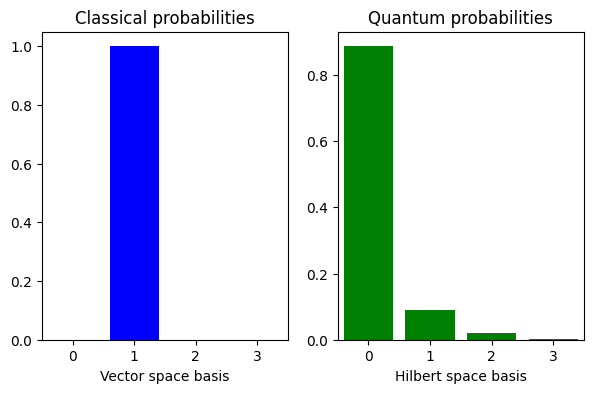

In [17]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()